<ipython-input-26-1b5c7136f064>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


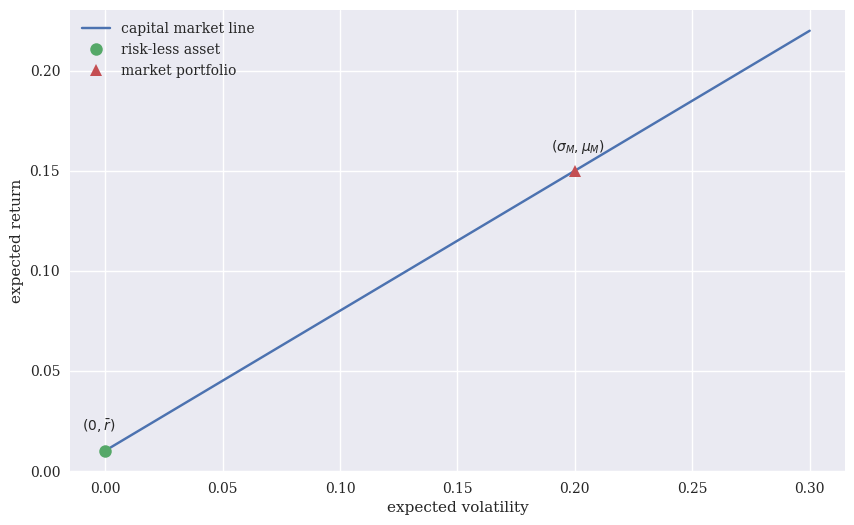

In [26]:
from pylab import plt, mpl
import numpy as np
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10, 6))
plt.plot((0, 0.3), (0.01, 0.22), label='capital market line')
plt.plot(0, 0.01, 'o', ms=9, label='risk-less asset')
plt.plot(0.2, 0.15, '^', ms=9, label='market portfolio')
plt.annotate('$(0, \\bar{r})$', (0, 0.01), (-0.01, 0.02))
plt.annotate('$(\sigma_M, \mu_M)$', (0.2, 0.15), (0.19, 0.16))
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend();

In [27]:
S0 = 10
S1 = np.array((20, 10, 5))
T0 = 10
T1 = np.array((1, 12, 13))
P = np.ones(3)/3
M0 = np.array((S0, T0))
M1 = np.array((S1, T1)).T
rM = M1 / M0 -1

#funzione di rendimento atteso
def mu(rX):
  return np.dot(P, rX)
#il rendimento atteso del portafoglio
def mu_phi(phi):
  return np.dot(phi, mu(rM))
phi_M = np.array((0.8, 0.2))
mu_M = mu_phi(phi_M)
mu_M

0.10666666666666666

In [28]:
#la varianza attesa del portafoglio
def var_phi(phi):
  cv = np.cov(rM.T, aweights=P, ddof=0)
  return np.dot(phi, np.dot(cv, phi))

#la volatilità attesa del portafoglio
def sigma_phi(phi):
  return var_phi(phi) ** 0.5

sigma_M = sigma_phi(phi_M)
sigma_M

0.39474323581566567

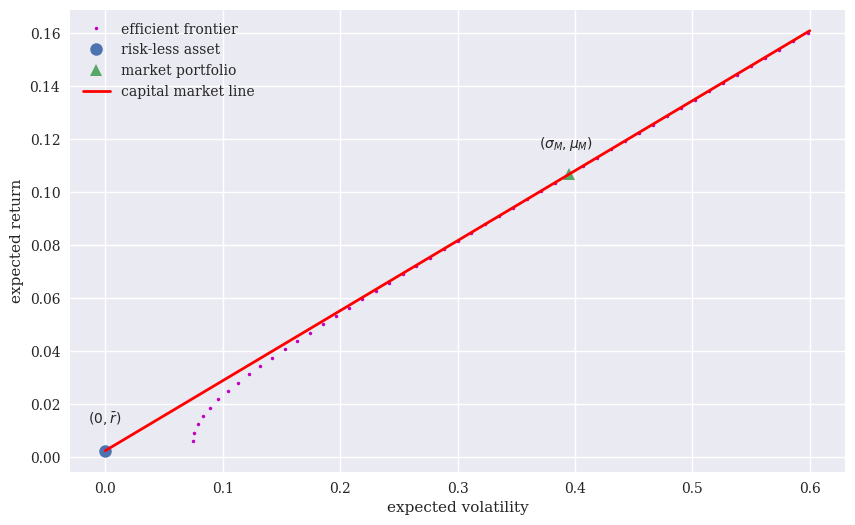

In [31]:
from scipy.optimize import minimize

cons = {'type': 'eq', 'fun': lambda phi: np.sum(phi) - 1}
bnds = ((0, 1), (0, 1))

min_var = minimize(sigma_phi, (0.5, 0.5), constraints=cons, bounds=bnds)

r = 0.0025

cons = [{'type': 'eq', 'fun': lambda phi: np.sum(phi) - 1},
                {'type': 'eq', 'fun': lambda phi: mu_phi(phi) - target}]

bnds = ((0, 1), (0, 1))

targets = np.linspace(mu_phi(min_var['x']), 0.16)

frontier = []
for target in targets:
    phi_eff = minimize(sigma_phi, (0.5, 0.5), constraints=cons, bounds=bnds)['x']
    frontier.append((sigma_phi(phi_eff), mu_phi(phi_eff)))
frontier = np.array(frontier)

plt.figure(figsize=(10, 6))
plt.plot(frontier[:, 0], frontier[:, 1], 'm.', ms=5,
                  label='efficient frontier')
plt.plot(0, r, 'o', ms=9, label='risk-less asset')
plt.plot(sigma_M, mu_M, '^', ms=9, label='market portfolio')
plt.plot((0, 0.6), (r, r + ((mu_M - r) / sigma_M) * 0.6),
                  'r', label='capital market line', lw=2.0)
plt.annotate('$(0, \\bar{r})$', (0, r), (-0.015, r + 0.01))
plt.annotate('$(\sigma_M, \mu_M)$', (sigma_M, mu_M),
                      (sigma_M - 0.025, mu_M + 0.01))
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend();

In [32]:
#la funzione di utilità nello spazio rischio-rendimento
def U(p):
    mu, sigma = p
    return mu - 1 / 2 * (sigma ** 2 + mu ** 2)

#la condizione che il portafoglio sia sulla CML
cons = {'type': 'eq','fun': lambda p: p[0] - (r + (mu_M - r) / sigma_M * p[1])}

opt = minimize(lambda p: -U(p), (0.1, 0.3), constraints=cons)
opt

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.034885186826739426
       x: [ 6.744e-02  2.461e-01]
     nit: 2
     jac: [-9.326e-01  2.461e-01]
    nfev: 6
    njev: 2

In [33]:
from sympy import *
init_printing(use_unicode=False, use_latex=False)

#definisce i simboli di SymPy
mu, sigma, b, v = symbols('mu sigma b v')

#risolve la funzione di utilità per u
sol = solve('mu - b / 2 * (sigma ** 2 + mu ** 2) - v', mu)
sol

        _________________________     _________________________     
       /    2      2                 /    2      2                  
 1 - \/  - b *sigma  - 2*b*v + 1   \/  - b *sigma  - 2*b*v + 1  + 1 
[--------------------------------, --------------------------------]
                b                                 b                 

In [34]:
#sostituisce i valori numerici per b, v
u1 = sol[0].subs({'b': 1, 'v': 0.1})
u1

       ______________
      /            2 
1 - \/  0.8 - sigma  

In [35]:
u2 = sol[0].subs({'b': 1, 'v': 0.125})
u2

       _______________
      /             2 
1 - \/  0.75 - sigma  

In [38]:
#genera funzioni richiamabili dalle equazioni risultanti
f1 = lambdify(sigma, u1)
f2 = lambdify(sigma, u2)

#specifica i valori per sigma su cui valutare le funzioni
sigma_ = np.linspace(0.0, 0.5)

#valuta le funzioni richiamabili per i due livelli diversi di utilità
u1_ = f1(sigma_)
u2_ = f2(sigma_)

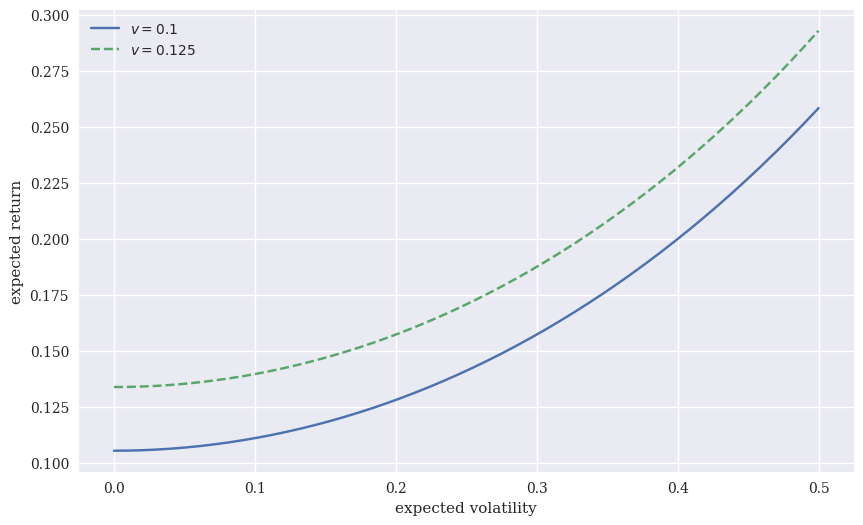

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(sigma_, u1_, label='$v=0.1$')
plt.plot(sigma_, u2_, '--', label='$v=0.125$')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend();

In [40]:
#definisce la curva di indifferenza per il livello di utilità ottimale
u = sol[0].subs({'b': 1, 'v': -opt['fun']})
u

       ____________________________
      /                          2 
1 - \/  0.930229626346521 - sigma  

In [41]:
f = lambdify(sigma, u)

In [42]:
#deriva i valori numerici per tracciare la curva di indifferenza
u_ = f(sigma_)
u_

array([0.03551588, 0.03556986, 0.03573181, 0.03600181, 0.03637992,
       0.03686629, 0.03746107, 0.03816447, 0.03897672, 0.03989811,
       0.04092894, 0.04206957, 0.04332039, 0.04468184, 0.04615438,
       0.04773854, 0.04943487, 0.05124397, 0.0531665 , 0.05520313,
       0.05735462, 0.05962175, 0.06200535, 0.06450633, 0.06712562,
       0.06986422, 0.07272319, 0.07570364, 0.07880677, 0.0820338 ,
       0.08538605, 0.08886491, 0.09247183, 0.09620834, 0.10007605,
       0.10407667, 0.10821199, 0.11248389, 0.11689434, 0.12144544,
       0.12613938, 0.13097849, 0.13596519, 0.14110206, 0.1463918 ,
       0.15183729, 0.15744154, 0.16320773, 0.16913925, 0.17523966])

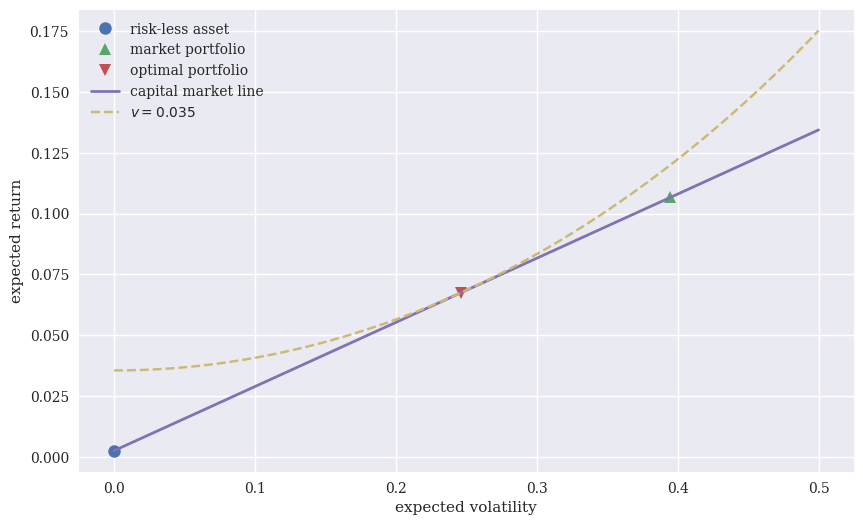

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(0, r, 'o', ms=9, label='risk-less asset')
plt.plot(sigma_M, mu_M, '^', ms=9, label='market portfolio')
plt.plot(opt['x'][1], opt['x'][0], 'v', ms=9, label='optimal portfolio')
plt.plot((0, 0.5), (r, r + (mu_M - r) / sigma_M * 0.5),
                  label='capital market line', lw=2.0)
plt.plot(sigma_, u_, '--', label='$v={}$'.format(-round(opt['fun'], 3)))
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.legend();